In [ ]:
# DONT RUNALL, RUN CELL BY CELL

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# Install PyTorch Geometric dependencies
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

# Install PyTorch Geometric itself
!pip install torch-geometric


Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, HeteroConv
from torch_geometric.data import HeteroData
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.nn import SAGEConv

In [ ]:
import torch
import torch_geometric

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")


PyTorch version: 2.5.1+cu121
PyTorch Geometric version: 2.6.1


In [ ]:
# 1. Load/Create Heterogeneous Data
data = HeteroData()

# Define user and item nodes with features
data['user'].x = torch.rand(100, 16)  # 100 users with 16 features
data['item'].x = torch.rand(100, 16)   # 100 items with 16 features

# Define edges for user-item interactions
user_item_edges = torch.randint(0, 100, (2, 200))  # 200 edges
data['user', 'interacts', 'item'].edge_index = user_item_edges
data['item', 'interacted_by', 'user'].edge_index = user_item_edges.flip(0)

# Move the data to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

In [ ]:
# 2. Negative Sampling Function
def generate_negative_edges(edge_index, num_users, num_items, num_neg_samples, device):
    neg_edge_user = torch.randint(0, num_users, (num_neg_samples,), device=device)
    neg_edge_item = torch.randint(0, num_items, (num_neg_samples,), device=device)
    return torch.stack([neg_edge_user, neg_edge_item], dim=0)

# Generate train and test splits
train_edges = user_item_edges[:, :160]  # First 80% for training
test_edges = user_item_edges[:, 160:]   # Last 20% for testing

num_neg_samples_train = train_edges.size(1)
num_neg_samples_test = test_edges.size(1)

train_neg_edges = generate_negative_edges(train_edges, 100, 50, num_neg_samples_train, device)
test_neg_edges = generate_negative_edges(test_edges, 100, 50, num_neg_samples_test, device)

# 3. Define the GNN Model
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Heterogeneous GNN layers
        self.hidden_channels = hidden_channels
        self.conv1 = HeteroConv({
            ('user', 'interacts', 'item'): SAGEConv((-1, -1), hidden_channels),
            ('item', 'interacted_by', 'user'): SAGEConv((-1, -1), hidden_channels)
        })
        self.conv2 = HeteroConv({
            ('user', 'interacts', 'item'): SAGEConv((-1, -1), hidden_channels),
            ('item', 'interacted_by', 'user'): SAGEConv((-1, -1), hidden_channels)
        })
        self.lin = Linear(hidden_channels, 1)  # For link prediction

    def forward(self, x_dict, edge_index_dict):
        # First GNN layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        # Second GNN layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

    def predict(self, edge_index, x_user, x_item):
      # Get user and item embeddings using edge indices
      user_emb = x_user[edge_index[0]]  # shape: [num_edges, hidden_channels]
      item_emb = x_item[edge_index[1]]  # shape: [num_edges, hidden_channels]

      # Compute the dot product of user and item embeddings
      scores = (user_emb * item_emb)  # shape: [num_edges]
      #print(user_emb.shape)
      #print(item_emb.shape)
      #print(scores.shape)

      # Reshape scores to [num_edges, 1] for the linear layer
      #scores = scores.unsqueeze(-1)  # [160] -> [160, 1]
      #scores = scores.repeat(1, 32)
      #output = self.lin(scores)      # [160, 1] -> [160, 1]

      # Apply sigmoid to get probabilities
      return torch.sigmoid(self.lin(scores))

# Initialize the model and optimizer
model = HeteroGNN(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 4. Training and Evaluation Loop
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    x_dict = model(data.x_dict, data.edge_index_dict)

    # Training positive and negative edges
    pos_train_preds = model.predict(train_edges, x_dict['user'], x_dict['item'])
    neg_train_preds = model.predict(train_neg_edges, x_dict['user'], x_dict['item'])

    train_labels = torch.cat([torch.ones(pos_train_preds.size(0), device=device),
                              torch.zeros(neg_train_preds.size(0), device=device)])
    train_preds = torch.cat([pos_train_preds, neg_train_preds])

    # Compute the loss
    # Compute the loss
    loss = F.binary_cross_entropy(train_preds.squeeze(-1), train_labels)

    loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        pos_test_preds = model.predict(test_edges, x_dict['user'], x_dict['item'])
        neg_test_preds = model.predict(test_neg_edges, x_dict['user'], x_dict['item'])

        test_labels = torch.cat([torch.ones(pos_test_preds.size(0), device=device),
                                 torch.zeros(neg_test_preds.size(0), device=device)])
        test_preds = torch.cat([pos_test_preds, neg_test_preds])

        auc = roc_auc_score(test_labels.cpu(), test_preds.cpu())

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test AUC: {auc:.4f}")


Epoch 1, Loss: 0.6951, Test AUC: 0.3944
Epoch 2, Loss: 0.6898, Test AUC: 0.6994
Epoch 3, Loss: 0.6846, Test AUC: 0.6831
Epoch 4, Loss: 0.6740, Test AUC: 0.6775
Epoch 5, Loss: 0.6550, Test AUC: 0.6731
Epoch 6, Loss: 0.6266, Test AUC: 0.6638
Epoch 7, Loss: 0.6213, Test AUC: 0.6344
Epoch 8, Loss: 0.7415, Test AUC: 0.6950
Epoch 9, Loss: 0.5768, Test AUC: 0.6625
Epoch 10, Loss: 0.6956, Test AUC: 0.6181
Epoch 11, Loss: 0.6090, Test AUC: 0.6444
Epoch 12, Loss: 0.5804, Test AUC: 0.6831
Epoch 13, Loss: 0.6275, Test AUC: 0.7069
Epoch 14, Loss: 0.6169, Test AUC: 0.7075
Epoch 15, Loss: 0.5786, Test AUC: 0.6925
Epoch 16, Loss: 0.5724, Test AUC: 0.6750
Epoch 17, Loss: 0.5903, Test AUC: 0.6619
Epoch 18, Loss: 0.5886, Test AUC: 0.6619
Epoch 19, Loss: 0.5626, Test AUC: 0.6812
Epoch 20, Loss: 0.5472, Test AUC: 0.7031
Epoch 21, Loss: 0.5576, Test AUC: 0.7131
Epoch 22, Loss: 0.5506, Test AUC: 0.7081
Epoch 23, Loss: 0.5244, Test AUC: 0.6931
Epoch 24, Loss: 0.5203, Test AUC: 0.6844
Epoch 25, Loss: 0.5236, T

In [ ]:
# 5. Link Analysis
def compute_common_neighbors(edge_index, num_nodes):
    # Compute the adjacency matrix
    adj = torch.zeros((num_nodes, num_nodes), device=device)
    adj[edge_index[0], edge_index[1]] = 1

    # Count common neighbors
    common_neighbors = adj @ adj
    return common_neighbors

def compute_jaccard_similarity(edge_index, num_nodes):
    # Compute the adjacency matrix
    adj = torch.zeros((num_nodes, num_nodes), device=device)
    adj[edge_index[0], edge_index[1]] = 1

    # Compute degree of each node
    degrees = adj.sum(dim=1)

    # Jaccard similarity: |N(u) ∩ N(v)| / |N(u) ∪ N(v)|
    union = degrees[edge_index[0]] + degrees[edge_index[1]] - (adj @ adj)[edge_index[0], edge_index[1]]
    intersection = (adj @ adj)[edge_index[0], edge_index[1]]
    jaccard_similarity = intersection / union
    return jaccard_similarity

# Example usage

In [ ]:
#dont run this cell
num_users = data['user'].x.size
num_items = data['item'].x.size
print(num_users)
print(num_items)

<built-in method size of Tensor object at 0x7bce02577dd0>
<built-in method size of Tensor object at 0x7bce023ecbd0>


In [ ]:
#Dont run this cell, Ignore it

# Compute link-based metrics for training edges
train_common_neighbors = compute_common_neighbors(train_edges, num_users)
train_jaccard_similarity = compute_jaccard_similarity(train_edges, num_users)

# Print some link analysis metrics for inspection
print("Link Analysis Metrics:")
print("Common Neighbors (Train):", train_common_neighbors[:5])
print("Jaccard Similarity (Train):", train_jaccard_similarity[:5])


TypeError: zeros() received an invalid combination of arguments - got (tuple, device=torch.device), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import HeteroConv, SAGEConv         #Semi-supervised Classification with Graph Convolutional Network
from torch_geometric.data import HeteroData
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, average_precision_score
#aupr
import torch.nn.functional as F


In [ ]:
# 1. Load/Create Heterogeneous Data
data = HeteroData()

# Define user and item nodes with features
data['user'].x = torch.rand(100, 16)  # 100 users with 16 features
data['item'].x = torch.rand(100, 16)  # 100 items with 16 features

# Define edges for user-item interactions
user_item_edges = torch.randint(0, 100, (2, 200))  # 200 edges
data['user', 'interacts', 'item'].edge_index = user_item_edges
data['item', 'interacted_by', 'user'].edge_index = user_item_edges.flip(0)

# Define user-to-user edges (e.g., based on similarity)
user_user_edges = torch.randint(0, 100, (2, 150))  # 150 random edges
data['user', 'connects', 'user'].edge_index = user_user_edges

# Define item-to-item edges (e.g., based on similarity or co-occurrence)
item_item_edges = torch.randint(0, 100, (2, 150))  # 150 random edges
data['item', 'similar', 'item'].edge_index = item_item_edges


# Move the data to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

NameError: name 'HeteroData' is not defined

In [ ]:
#Dont run this cell, the code is not build for this data, If u did run all then run above cell and all below cells then

from torch_geometric.data import HeteroData
import torch

# Initialize heterogeneous data
data = HeteroData()

# Define user, item, and new types of nodes (categories and reviews)
data['user'].x = torch.rand(200, 16)  # 200 users with 16 features
data['item'].x = torch.rand(300, 16)  # 300 items with 16 features
data['category'].x = torch.rand(50, 8)  # 50 categories with 8 features
data['review'].x = torch.rand(500, 12)  # 500 reviews with 12 features

# User-Item Interactions
user_item_edges = torch.randint(0, 200, (2, 500))  # 500 edges
data['user', 'interacts', 'item'].edge_index = user_item_edges
data['item', 'interacted_by', 'user'].edge_index = user_item_edges.flip(0)

# User-to-User Connections
user_user_edges = torch.randint(0, 200, (2, 300))  # 300 user-to-user edges
data['user', 'connects', 'user'].edge_index = user_user_edges

# Item-to-Item Similarity
item_item_edges = torch.randint(0, 300, (2, 400))  # 400 item-to-item edges
data['item', 'similar', 'item'].edge_index = item_item_edges

# Item-to-Category Relationships
item_category_edges = torch.randint(0, 300, (2, 600))  # 600 item-to-category edges
data['item', 'belongs_to', 'category'].edge_index = item_category_edges
data['category', 'has', 'item'].edge_index = item_category_edges.flip(0)

# User-to-Review Interactions
user_review_edges = torch.randint(0, 200, (2, 700))  # 700 user-to-review edges
data['user', 'writes', 'review'].edge_index = user_review_edges
data['review', 'written_by', 'user'].edge_index = user_review_edges.flip(0)

# Item-to-Review Relationships
item_review_edges = torch.randint(0, 300, (2, 700))  # 700 item-to-review edges
data['item', 'has_review', 'review'].edge_index = item_review_edges
data['review', 'review_of', 'item'].edge_index = item_review_edges.flip(0)

# User and Item Ratings
data['user'].y = torch.randint(0, 6, (200,))  # User satisfaction rating (0-5)
data['item'].y = torch.randint(0, 6, (300,))  # Item popularity rating (0-5)

# Review Sentiment Labels
data['review'].y = torch.randint(0, 3, (500,))  # Sentiment classes (0 = Negative, 1 = Neutral, 2 = Positive)

# Move the data to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Print a summary of the heterogeneous graph
print(data)


HeteroData(
  user={
    x=[200, 16],
    y=[200],
  },
  item={
    x=[300, 16],
    y=[300],
  },
  category={ x=[50, 8] },
  review={
    x=[500, 12],
    y=[500],
  },
  (user, interacts, item)={ edge_index=[2, 500] },
  (item, interacted_by, user)={ edge_index=[2, 500] },
  (user, connects, user)={ edge_index=[2, 300] },
  (item, similar, item)={ edge_index=[2, 400] },
  (item, belongs_to, category)={ edge_index=[2, 600] },
  (category, has, item)={ edge_index=[2, 600] },
  (user, writes, review)={ edge_index=[2, 700] },
  (review, written_by, user)={ edge_index=[2, 700] },
  (item, has_review, review)={ edge_index=[2, 700] },
  (review, review_of, item)={ edge_index=[2, 700] }
)


In [ ]:
# 2. Negative Sampling Function
def generate_negative_edges(edge_index, num_users, num_items, num_neg_samples, device):
    neg_edges = set()
    pos_edges = set(tuple(e) for e in edge_index.T.cpu().numpy())
    while len(neg_edges) < num_neg_samples:
        neg_edge = (torch.randint(0, num_users, (1,), device=device).item(),
                    torch.randint(0, num_items, (1,), device=device).item())
        if neg_edge not in pos_edges:  # Avoid overlaps with positive edges
            neg_edges.add(neg_edge)
    neg_edges = torch.tensor(list(neg_edges), device=device).T
    return neg_edges


# Generate train and test splits
train_edges = user_item_edges[:, :160]  # First 80% for training
test_edges = user_item_edges[:, 160:]   # Last 20% for testing

num_neg_samples_train = train_edges.size(1)
num_neg_samples_test = test_edges.size(1)

train_neg_edges = generate_negative_edges(train_edges, 100, 100, num_neg_samples_train, device)
test_neg_edges = generate_negative_edges(test_edges, 100, 100, num_neg_samples_test, device)

# 3. Define the GNN Model
class ExtendedHeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.conv1 = HeteroConv({
            ('user', 'interacts', 'item'): SAGEConv((-1, -1), hidden_channels),
            ('item', 'interacted_by', 'user'): SAGEConv((-1, -1), hidden_channels),
            ('user', 'connects', 'user'): SAGEConv((-1, -1), hidden_channels),
            ('item', 'similar', 'item'): SAGEConv((-1, -1), hidden_channels),
        })
        self.conv2 = HeteroConv({
            ('user', 'interacts', 'item'): SAGEConv((-1, -1), hidden_channels),
            ('item', 'interacted_by', 'user'): SAGEConv((-1, -1), hidden_channels),
            ('user', 'connects', 'user'): SAGEConv((-1, -1), hidden_channels),
            ('item', 'similar', 'item'): SAGEConv((-1, -1), hidden_channels),
        })
        self.lin = Linear(hidden_channels * 2, 1)

    def forward(self, x_dict, edge_index_dict):
        # First GNN layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        # Second GNN layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

    def predict(self, edge_index, x_src, x_dst):
        # Extract embeddings for the edges
        src_emb = x_src[edge_index[0]]
        dst_emb = x_dst[edge_index[1]]
        # Concatenate embeddings for prediction
        scores = torch.cat([src_emb, dst_emb], dim=-1)
        return torch.sigmoid(self.lin(scores)).squeeze()


# Generate negative samples for user-user and item-item relationships
num_neg_samples_uu = user_user_edges.size(1)
num_neg_samples_ii = item_item_edges.size(1)

neg_user_user_edges = generate_negative_edges(user_user_edges, 100, 100, num_neg_samples_uu, device)
neg_item_item_edges = generate_negative_edges(item_item_edges, 100, 100, num_neg_samples_ii, device)

model = ExtendedHeteroGNN(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def init_weights(module):
    if isinstance(module, Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

model.apply(init_weights)



# Training loop
for epoch in range(1, 401):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    x_dict = model(data.x_dict, data.edge_index_dict)

    # Training positive and negative edges
    pos_train_preds_ui = model.predict(train_edges, x_dict['user'], x_dict['item'])
    neg_train_preds_ui = model.predict(train_neg_edges, x_dict['user'], x_dict['item'])

    pos_train_preds_uu = model.predict(user_user_edges, x_dict['user'], x_dict['user'])
    neg_train_preds_uu = model.predict(neg_user_user_edges, x_dict['user'], x_dict['user'])

    pos_train_preds_ii = model.predict(item_item_edges, x_dict['item'], x_dict['item'])
    neg_train_preds_ii = model.predict(neg_item_item_edges, x_dict['item'], x_dict['item'])

    # Combine predictions and labels
    train_labels_ui = torch.cat([torch.ones(pos_train_preds_ui.size(0), device=device),
                                 torch.zeros(neg_train_preds_ui.size(0), device=device)])
    train_preds_ui = torch.cat([pos_train_preds_ui, neg_train_preds_ui])

    train_labels_uu = torch.cat([torch.ones(pos_train_preds_uu.size(0), device=device),
                                 torch.zeros(neg_train_preds_uu.size(0), device=device)])
    train_preds_uu = torch.cat([pos_train_preds_uu, neg_train_preds_uu])

    train_labels_ii = torch.cat([torch.ones(pos_train_preds_ii.size(0), device=device),
                                 torch.zeros(neg_train_preds_ii.size(0), device=device)])
    train_preds_ii = torch.cat([pos_train_preds_ii, neg_train_preds_ii])

    # Compute the loss
    loss_ui = F.binary_cross_entropy(train_preds_ui.squeeze(), train_labels_ui)
    loss_uu = F.binary_cross_entropy(train_preds_uu.squeeze(), train_labels_uu)
    loss_ii = F.binary_cross_entropy(train_preds_ii.squeeze(), train_labels_ii)

    total_loss = loss_ui + loss_uu + loss_ii

    total_loss.backward()
    optimizer.step()

    # Print loss
    print(f"Epoch {epoch}, Loss: {total_loss.item():.4f}")


Epoch 1, Loss: 2.2722
Epoch 2, Loss: 2.1789
Epoch 3, Loss: 2.1265
Epoch 4, Loss: 2.1022
Epoch 5, Loss: 2.0860
Epoch 6, Loss: 2.0667
Epoch 7, Loss: 2.0442
Epoch 8, Loss: 2.0221
Epoch 9, Loss: 2.0036
Epoch 10, Loss: 1.9899
Epoch 11, Loss: 1.9795
Epoch 12, Loss: 1.9701
Epoch 13, Loss: 1.9595
Epoch 14, Loss: 1.9466
Epoch 15, Loss: 1.9321
Epoch 16, Loss: 1.9173
Epoch 17, Loss: 1.9037
Epoch 18, Loss: 1.8915
Epoch 19, Loss: 1.8802
Epoch 20, Loss: 1.8691
Epoch 21, Loss: 1.8574
Epoch 22, Loss: 1.8452
Epoch 23, Loss: 1.8333
Epoch 24, Loss: 1.8223
Epoch 25, Loss: 1.8123
Epoch 26, Loss: 1.8030
Epoch 27, Loss: 1.7936
Epoch 28, Loss: 1.7840
Epoch 29, Loss: 1.7742
Epoch 30, Loss: 1.7647
Epoch 31, Loss: 1.7559
Epoch 32, Loss: 1.7476
Epoch 33, Loss: 1.7395
Epoch 34, Loss: 1.7313
Epoch 35, Loss: 1.7231
Epoch 36, Loss: 1.7150
Epoch 37, Loss: 1.7074
Epoch 38, Loss: 1.6998
Epoch 39, Loss: 1.6920
Epoch 40, Loss: 1.6839
Epoch 41, Loss: 1.6760
Epoch 42, Loss: 1.6681
Epoch 43, Loss: 1.6601
Epoch 44, Loss: 1.65

In [ ]:
# Training loop with ROC AUC and AUPR scores
for epoch in range(1, 401):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    x_dict = model(data.x_dict, data.edge_index_dict)

    # Training positive and negative edges
    pos_train_preds_ui = model.predict(train_edges, x_dict['user'], x_dict['item'])
    neg_train_preds_ui = model.predict(train_neg_edges, x_dict['user'], x_dict['item'])

    pos_train_preds_uu = model.predict(user_user_edges, x_dict['user'], x_dict['user'])
    neg_train_preds_uu = model.predict(neg_user_user_edges, x_dict['user'], x_dict['user'])

    pos_train_preds_ii = model.predict(item_item_edges, x_dict['item'], x_dict['item'])
    neg_train_preds_ii = model.predict(neg_item_item_edges, x_dict['item'], x_dict['item'])

    # Combine predictions and labels
    train_labels_ui = torch.cat([torch.ones(pos_train_preds_ui.size(0), device=device),
                                 torch.zeros(neg_train_preds_ui.size(0), device=device)])
    train_preds_ui = torch.cat([pos_train_preds_ui, neg_train_preds_ui])

    train_labels_uu = torch.cat([torch.ones(pos_train_preds_uu.size(0), device=device),
                                 torch.zeros(neg_train_preds_uu.size(0), device=device)])
    train_preds_uu = torch.cat([pos_train_preds_uu, neg_train_preds_uu])

    train_labels_ii = torch.cat([torch.ones(pos_train_preds_ii.size(0), device=device),
                                 torch.zeros(neg_train_preds_ii.size(0), device=device)])
    train_preds_ii = torch.cat([pos_train_preds_ii, neg_train_preds_ii])

    # Compute the loss
    loss_ui = F.binary_cross_entropy(train_preds_ui.squeeze(), train_labels_ui)
    loss_uu = F.binary_cross_entropy(train_preds_uu.squeeze(), train_labels_uu)
    loss_ii = F.binary_cross_entropy(train_preds_ii.squeeze(), train_labels_ii)

    total_loss = loss_ui + loss_uu + loss_ii

    total_loss.backward()
    optimizer.step()

    # Compute ROC AUC and AUPR for each edge type
    # Convert predictions and labels to numpy arrays for sklearn functions
    train_preds_ui_np = train_preds_ui.cpu().detach().numpy()
    train_labels_ui_np = train_labels_ui.cpu().detach().numpy()

    train_preds_uu_np = train_preds_uu.cpu().detach().numpy()
    train_labels_uu_np = train_labels_uu.cpu().detach().numpy()

    train_preds_ii_np = train_preds_ii.cpu().detach().numpy()
    train_labels_ii_np = train_labels_ii.cpu().detach().numpy()

    # Calculate ROC AUC and AUPR scores
    roc_auc_ui = roc_auc_score(train_labels_ui_np, train_preds_ui_np)
    aupr_ui = average_precision_score(train_labels_ui_np, train_preds_ui_np)

    roc_auc_uu = roc_auc_score(train_labels_uu_np, train_preds_uu_np)
    aupr_uu = average_precision_score(train_labels_uu_np, train_preds_uu_np)

    roc_auc_ii = roc_auc_score(train_labels_ii_np, train_preds_ii_np)
    aupr_ii = average_precision_score(train_labels_ii_np, train_preds_ii_np)

    # Print metrics
    print(f"Epoch {epoch}, Loss: {total_loss.item():.4f}, "
          f"ROC AUC (UI): {roc_auc_ui:.4f}, AUPR (UI): {aupr_ui:.4f}, "
          f"ROC AUC (UU): {roc_auc_uu:.4f}, AUPR (UU): {aupr_uu:.4f}, "
          f"ROC AUC (II): {roc_auc_ii:.4f}, AUPR (II): {aupr_ii:.4f}")


Epoch 1, Loss: 0.4450, ROC AUC (UI): 0.9970, AUPR (UI): 0.9971, ROC AUC (UU): 0.9827, AUPR (UU): 0.9844, ROC AUC (II): 0.9793, AUPR (II): 0.9830
Epoch 2, Loss: 0.4442, ROC AUC (UI): 0.9971, AUPR (UI): 0.9971, ROC AUC (UU): 0.9827, AUPR (UU): 0.9844, ROC AUC (II): 0.9793, AUPR (II): 0.9830
Epoch 3, Loss: 0.4436, ROC AUC (UI): 0.9971, AUPR (UI): 0.9971, ROC AUC (UU): 0.9828, AUPR (UU): 0.9845, ROC AUC (II): 0.9793, AUPR (II): 0.9830
Epoch 4, Loss: 0.4432, ROC AUC (UI): 0.9971, AUPR (UI): 0.9971, ROC AUC (UU): 0.9827, AUPR (UU): 0.9844, ROC AUC (II): 0.9793, AUPR (II): 0.9830
Epoch 5, Loss: 0.4430, ROC AUC (UI): 0.9971, AUPR (UI): 0.9972, ROC AUC (UU): 0.9828, AUPR (UU): 0.9845, ROC AUC (II): 0.9793, AUPR (II): 0.9830
Epoch 6, Loss: 0.4427, ROC AUC (UI): 0.9971, AUPR (UI): 0.9971, ROC AUC (UU): 0.9829, AUPR (UU): 0.9845, ROC AUC (II): 0.9793, AUPR (II): 0.9830
Epoch 7, Loss: 0.4424, ROC AUC (UI): 0.9971, AUPR (UI): 0.9972, ROC AUC (UU): 0.9829, AUPR (UU): 0.9846, ROC AUC (II): 0.9795, AUP

In [ ]:
# Analyze link predictions after training
model.eval()
with torch.no_grad():
    # Predict on all edges (positive and negative in the test set)
    pos_test_preds = model.predict(test_edges, x_dict['user'], x_dict['item'])
    neg_test_preds = model.predict(test_neg_edges, x_dict['user'], x_dict['item'])

    # Combine predictions
    all_test_preds = torch.cat([pos_test_preds, neg_test_preds])
    all_test_labels = torch.cat([torch.ones(pos_test_preds.size(0), device=device),
                                 torch.zeros(neg_test_preds.size(0), device=device)])

    # Sort predictions by confidence
    sorted_indices = torch.argsort(all_test_preds, descending=True)
    sorted_preds = all_test_preds[sorted_indices]
    sorted_labels = all_test_labels[sorted_indices]

    # Display high-confidence predictions
    print("\n--- High Confidence Predictions ---")
    for i in range(10):  # Top 10 predictions
        label = "Positive" if sorted_labels[i].item() == 1 else "Negative"
        print(f"Prediction: {sorted_preds[i].item():.4f}, Label: {label}")

    # Display low-confidence predictions
    print("\n--- Low Confidence Predictions ---")
    for i in range(-1, -11, -1):  # Bottom 10 predictions
        label = "Positive" if sorted_labels[i].item() == 1 else "Negative"
        print(f"Prediction: {sorted_preds[i].item():.4f}, Label: {label}")



--- High Confidence Predictions ---
Prediction: 1.0000, Label: Positive
Prediction: 1.0000, Label: Positive
Prediction: 1.0000, Label: Positive
Prediction: 1.0000, Label: Positive
Prediction: 1.0000, Label: Positive
Prediction: 1.0000, Label: Positive
Prediction: 1.0000, Label: Positive
Prediction: 1.0000, Label: Positive
Prediction: 1.0000, Label: Positive
Prediction: 1.0000, Label: Positive

--- Low Confidence Predictions ---
Prediction: 0.0000, Label: Negative
Prediction: 0.0000, Label: Negative
Prediction: 0.0000, Label: Negative
Prediction: 0.0000, Label: Negative
Prediction: 0.0000, Label: Negative
Prediction: 0.0000, Label: Positive
Prediction: 0.0000, Label: Negative
Prediction: 0.0000, Label: Positive
Prediction: 0.0000, Label: Positive
Prediction: 0.0000, Label: Negative


In [ ]:
def generalized_node_to_node_analysis(model, data, node_pairs, source_type, target_type, device):
    """
    Perform generalized node-to-node analysis for any type of relationship.

    Args:
        model: The trained GNN model.
        data: Heterogeneous graph data.
        node_pairs: Pairs of nodes (source and target) to analyze.
        source_type: Type of source nodes (e.g., 'user', 'item').
        target_type: Type of target nodes (e.g., 'user', 'item').
        device: Device to run computations.

    Returns:
        Scores for each node pair.
    """
    # Ensure model is in evaluation mode
    model.eval()
    with torch.no_grad():
        # Forward pass to get node embeddings
        x_dict = model(data.x_dict, data.edge_index_dict)

        # Extract embeddings dynamically based on source and target types
        source_embeddings = x_dict[source_type]
        target_embeddings = x_dict[target_type]

        # Compute scores for the given node pairs
        source_nodes, target_nodes = node_pairs
        source_emb = source_embeddings[source_nodes]
        target_emb = target_embeddings[target_nodes]

        # Concatenate source and target embeddings
        scores = torch.cat([source_emb, target_emb], dim=-1)
        scores = torch.sigmoid(model.lin(scores)).squeeze()

    return scores

# Define pairs for different relationships
num_nodes = 10  # Adjust based on the number of nodes to analyze
node_pairs_user_to_item = (torch.arange(num_nodes, device=device), torch.arange(num_nodes, device=device))
node_pairs_item_to_user = (torch.arange(num_nodes, device=device), torch.arange(num_nodes, device=device))
node_pairs_user_to_user = (torch.arange(num_nodes, device=device), torch.arange(num_nodes, device=device))
node_pairs_item_to_item = (torch.arange(num_nodes, device=device), torch.arange(num_nodes, device=device))

# Analyze different relationships
scores_user_to_item = generalized_node_to_node_analysis(model, data, node_pairs_user_to_item, 'user', 'item', device)
scores_item_to_user = generalized_node_to_node_analysis(model, data, node_pairs_item_to_user, 'item', 'user', device)
scores_user_to_user = generalized_node_to_node_analysis(model, data, node_pairs_user_to_user, 'user', 'user', device)
scores_item_to_item = generalized_node_to_node_analysis(model, data, node_pairs_item_to_item, 'item', 'item', device)

# Print results
print("\n--- User-to-Item Scores ---")
for i, (user, item) in enumerate(zip(node_pairs_user_to_item[0].cpu().numpy(), node_pairs_user_to_item[1].cpu().numpy())):
    print(f"User {user} -> Item {item}: Score = {scores_user_to_item[i].item():.4f}")

print("\n--- Item-to-User Scores ---")
for i, (item, user) in enumerate(zip(node_pairs_item_to_user[0].cpu().numpy(), node_pairs_item_to_user[1].cpu().numpy())):
    print(f"Item {item} -> User {user}: Score = {scores_item_to_user[i].item():.4f}")

print("\n--- User-to-User Scores ---")
for i, (user1, user2) in enumerate(zip(node_pairs_user_to_user[0].cpu().numpy(), node_pairs_user_to_user[1].cpu().numpy())):
    print(f"User {user1} -> User {user2}: Score = {scores_user_to_user[i].item():.4f}")

print("\n--- Item-to-Item Scores ---")
for i, (item1, item2) in enumerate(zip(node_pairs_item_to_item[0].cpu().numpy(), node_pairs_item_to_item[1].cpu().numpy())):
    print(f"Item {item1} -> Item {item2}: Score = {scores_item_to_item[i].item():.4f}")



--- User-to-Item Scores ---
User 0 -> Item 0: Score = 0.0160
User 1 -> Item 1: Score = 0.0307
User 2 -> Item 2: Score = 0.9372
User 3 -> Item 3: Score = 0.9754
User 4 -> Item 4: Score = 0.0007
User 5 -> Item 5: Score = 0.0125
User 6 -> Item 6: Score = 0.9570
User 7 -> Item 7: Score = 0.0001
User 8 -> Item 8: Score = 0.0000
User 9 -> Item 9: Score = 0.0002

--- Item-to-User Scores ---
Item 0 -> User 0: Score = 0.0000
Item 1 -> User 1: Score = 0.0026
Item 2 -> User 2: Score = 0.0000
Item 3 -> User 3: Score = 0.0001
Item 4 -> User 4: Score = 0.0107
Item 5 -> User 5: Score = 0.4100
Item 6 -> User 6: Score = 0.0114
Item 7 -> User 7: Score = 0.0000
Item 8 -> User 8: Score = 0.0000
Item 9 -> User 9: Score = 0.0000

--- User-to-User Scores ---
User 0 -> User 0: Score = 0.0367
User 1 -> User 1: Score = 0.1097
User 2 -> User 2: Score = 0.0000
User 3 -> User 3: Score = 0.0753
User 4 -> User 4: Score = 0.0012
User 5 -> User 5: Score = 0.0148
User 6 -> User 6: Score = 0.0301
User 7 -> User 7: Scor

In [ ]:
def generalized_node_to_node_analysis(model, data, node_pairs, source_type, target_type, device):
    """
    Perform generalized node-to-node analysis for any type of relationship.

    Args:
        model: The trained GNN model.
        data: Heterogeneous graph data.
        node_pairs: Pairs of nodes (source and target) to analyze. Should be a tuple of tensors.
        source_type: Type of source nodes (e.g., 'user', 'item').
        target_type: Type of target nodes (e.g., 'user', 'item').
        device: Device to run computations.

    Returns:
        Scores for each node pair.
    """
    # Ensure model is in evaluation mode
    model.eval()
    with torch.no_grad():
        # Forward pass to get node embeddings
        x_dict = model(data.x_dict, data.edge_index_dict)

        # Extract embeddings dynamically based on source and target types
        source_embeddings = x_dict[source_type]
        target_embeddings = x_dict[target_type]

        # Compute scores for the given node pairs
        source_nodes, target_nodes = node_pairs
        source_emb = source_embeddings[source_nodes]
        target_emb = target_embeddings[target_nodes]

        # Concatenate source and target embeddings
        scores = torch.cat([source_emb, target_emb], dim=-1)
        scores = torch.sigmoid(model.lin(scores)).squeeze()

    return scores


# Example Usage with User-Selected Nodes
selected_users = torch.tensor([0, 1, 2, 3], device=device)  # Users to analyze
selected_items = torch.tensor([4, 5, 6, 7], device=device)  # Items to analyze

node_pairs_user_to_item = (selected_users, selected_items)
scores_user_to_item = generalized_node_to_node_analysis(
    model, data, node_pairs_user_to_item, 'user', 'item', device
)

# Print Results for User-to-Item Analysis
print("\n--- Selected User-to-Item Scores ---")
for i, (user, item) in enumerate(zip(node_pairs_user_to_item[0].cpu().numpy(), node_pairs_user_to_item[1].cpu().numpy())):
    print(f"User {user} -> Item {item}: Score = {scores_user_to_item[i].item():.4f}")



--- Selected User-to-Item Scores ---
User 0 -> Item 4: Score = 0.0041
User 1 -> Item 5: Score = 0.7027
User 2 -> Item 6: Score = 0.9902
User 3 -> Item 7: Score = 0.9495


In [ ]:
#Probability of link between them (ie. probability of interation)

def generalized_analysis_with_type(model, data, relationship_type, source_nodes, target_nodes, device):
    """
    Perform generalized analysis for selected relationship types and node pairs.

    Args:
        model: The trained GNN model.
        data: Heterogeneous graph data.
        relationship_type: Type of relationship ('user-to-user', 'item-to-item', 'user-to-item').
        source_nodes: Tensor of source node indices.
        target_nodes: Tensor of target node indices.
        device: Device to run computations.

    Returns:
        Scores for each node pair.
    """
    # Ensure model is in evaluation mode
    model.eval()
    with torch.no_grad():
        # Forward pass to get node embeddings
        x_dict = model(data.x_dict, data.edge_index_dict)

        # Select embeddings based on relationship type
        if relationship_type == 'user-to-user':
            source_type = target_type = 'user'
        elif relationship_type == 'item-to-item':
            source_type = target_type = 'item'
        elif relationship_type == 'user-to-item':
            source_type, target_type = 'user', 'item'
        else:
            raise ValueError("Invalid relationship_type. Choose from 'user-to-user', 'item-to-item', or 'user-to-item'.")

        # Extract embeddings
        source_embeddings = x_dict[source_type]
        target_embeddings = x_dict[target_type]

        # Compute scores for the given node pairs
        source_emb = source_embeddings[source_nodes]
        target_emb = target_embeddings[target_nodes]

        # Concatenate source and target embeddings
        scores = torch.cat([source_emb, target_emb], dim=-1)
        scores = torch.sigmoid(model.lin(scores)).squeeze()

    return scores


# Analyze and display results for all relationship types
relationship_types = ['user-to-user', 'item-to-item', 'user-to-item']
node_pairs = {
    'user-to-user': (torch.tensor([0, 1, 2], device=device), torch.tensor([3, 4, 5], device=device)),
    'item-to-item': (torch.tensor([10, 11, 12], device=device), torch.tensor([13, 14, 15], device=device)),
    'user-to-item': (torch.tensor([0, 1, 2], device=device), torch.tensor([5, 6, 7], device=device)),
}

for relationship_type in relationship_types:
    source_nodes, target_nodes = node_pairs[relationship_type]
    scores = generalized_analysis_with_type(model, data, relationship_type, source_nodes, target_nodes, device)

    # Print results
    print(f"\n--- {relationship_type.replace('-', ' ').capitalize()} Scores ---")
    for i, (src, tgt) in enumerate(zip(source_nodes.cpu().numpy(), target_nodes.cpu().numpy())):
        print(f"{relationship_type.split('-')[0].capitalize()} {src} -> {relationship_type.split('-')[1].capitalize()} {tgt}: Score = {scores[i].item():.4f}")



--- User to user Scores ---
User 0 -> To 3: Score = 0.0000
User 1 -> To 4: Score = 0.2719
User 2 -> To 5: Score = 0.6681

--- Item to item Scores ---
Item 10 -> To 13: Score = 0.0000
Item 11 -> To 14: Score = 0.0001
Item 12 -> To 15: Score = 0.0132

--- User to item Scores ---
User 0 -> To 5: Score = 0.0429
User 1 -> To 6: Score = 0.9930
User 2 -> To 7: Score = 0.0567


In [ ]:
pip install matplotlib networkx torch-geometric


<ipython-input-26-fc9461201e21>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', len(unique_node_types))


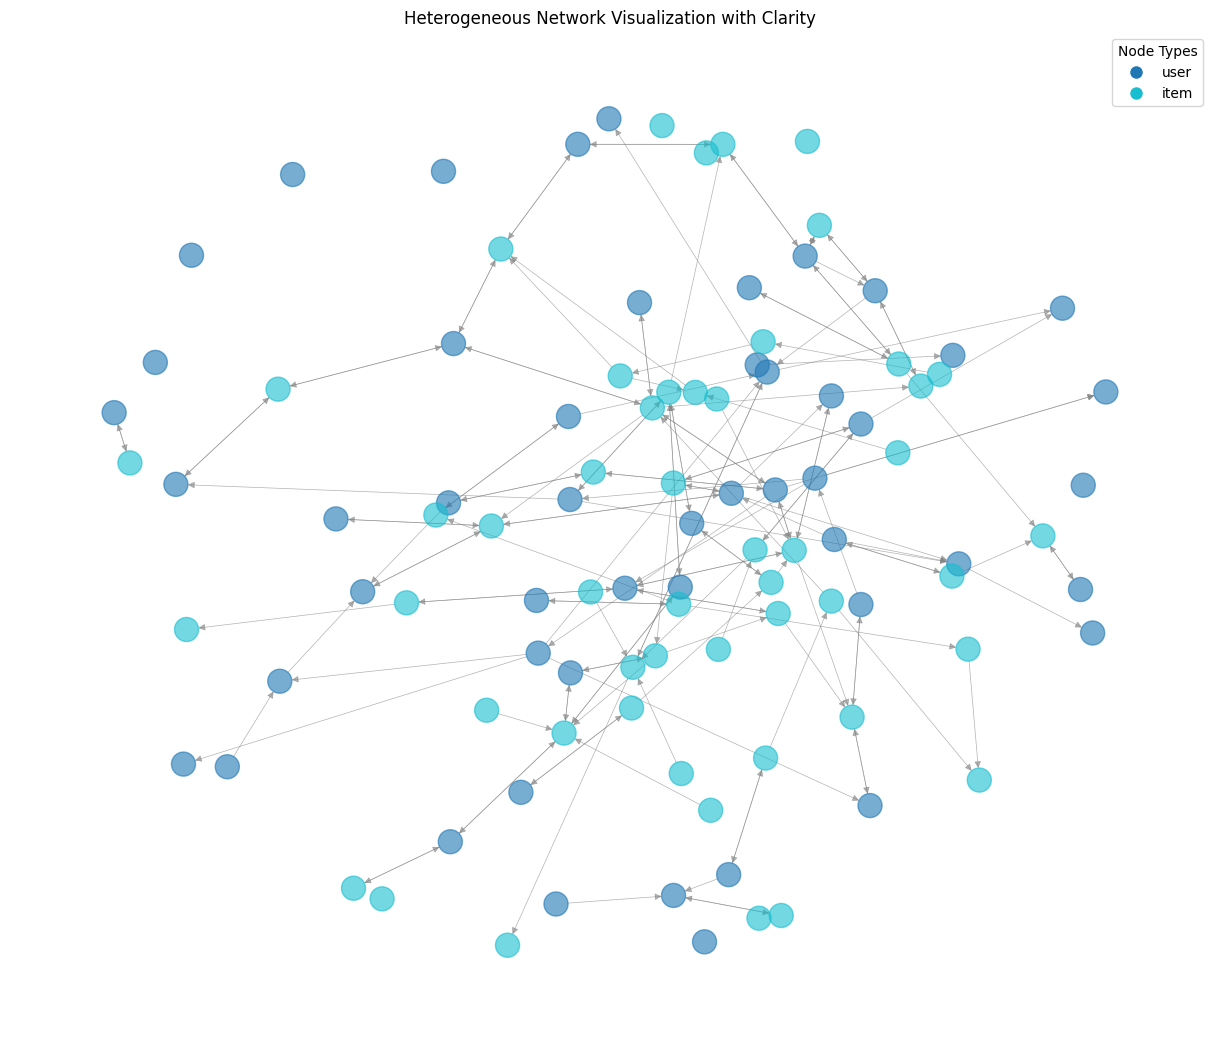

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_hetero_graph_with_clarity(data, layout='kamada_kawai', subset_size=None):
    """
    Visualize the heterogeneous graph with options to reduce clustering and focus on subsets.

    Args:
    - data: The HeteroData object containing the graph.
    - layout: Layout algorithm for positioning nodes ('kamada_kawai', 'spring', 'circular', etc.).
    - subset_size: Number of nodes per type to display (None for full graph).
    """
    # Create an empty NetworkX graph
    nx_graph = nx.DiGraph()

    # Add nodes with type attributes
    for node_type, node_data in data.x_dict.items():
        num_nodes = node_data.size(0)
        if subset_size:
            nodes_to_add = min(subset_size, num_nodes)
        else:
            nodes_to_add = num_nodes

        for i in range(nodes_to_add):
            nx_graph.add_node(f"{node_type}_{i}", type=node_type)

    # Add edges with edge types
    for (src, rel, dst), edge_index in data.edge_index_dict.items():
        for i in range(edge_index.size(1)):
            src_node = f"{src}_{edge_index[0, i].item()}"
            dst_node = f"{dst}_{edge_index[1, i].item()}"
            if src_node in nx_graph and dst_node in nx_graph:  # Check if nodes exist in the subset
                nx_graph.add_edge(src_node, dst_node, relation=rel)

    # Set node colors by type
    unique_node_types = list(data.x_dict.keys())
    color_palette = plt.cm.get_cmap('tab10', len(unique_node_types))
    color_map = {node_type: color_palette(i) for i, node_type in enumerate(unique_node_types)}
    node_colors = [color_map[attr['type']] for _, attr in nx_graph.nodes(data=True)]

    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(nx_graph, seed=42, k=0.3, iterations=50)
    elif layout == 'circular':
        pos = nx.circular_layout(nx_graph)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(nx_graph)
    else:
        raise ValueError(f"Unsupported layout: {layout}")

    # Draw the graph with reduced clutter
    plt.figure(figsize=(12, 10))
    nx.draw(
        nx_graph, pos, node_color=node_colors, with_labels=False,  # Hide labels to reduce clutter
        node_size=300, font_size=8, arrows=True, edge_color="gray", alpha=0.6, width=0.5
    )

    # Add legend for node types
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[node_type], markersize=10, label=node_type)
        for node_type in unique_node_types
    ]
    plt.legend(handles=legend_elements, loc='best', fontsize=10, title="Node Types")
    plt.title("Heterogeneous Network Visualization with Clarity")
    plt.show()

# Call the updated visualization function
visualize_hetero_graph_with_clarity(data, layout='spring', subset_size=50)


<ipython-input-26-fc9461201e21>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', len(unique_node_types))


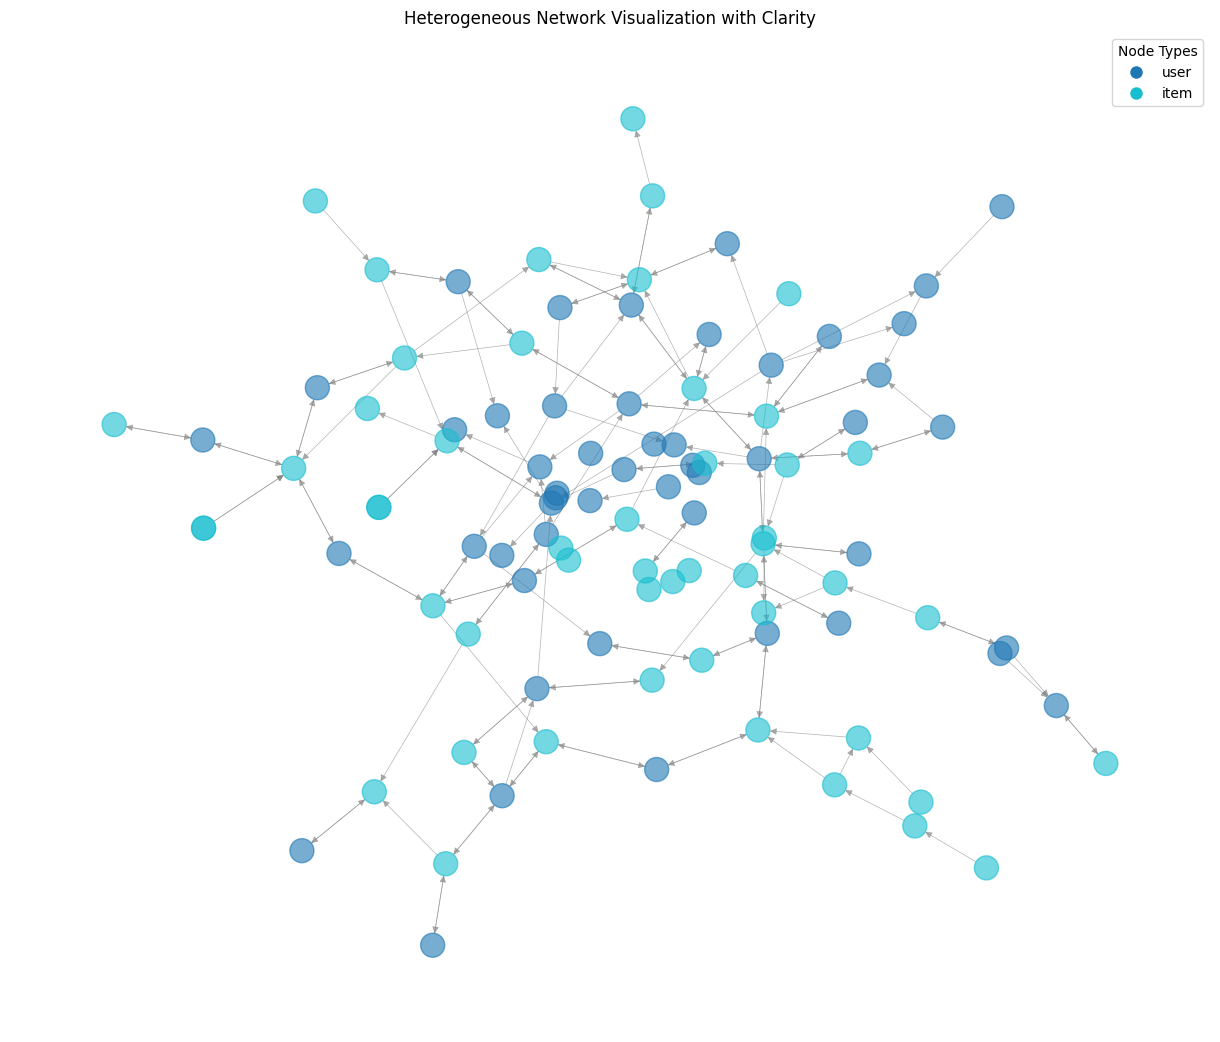

In [ ]:
visualize_hetero_graph_with_clarity(data, layout='kamada_kawai', subset_size=50)

<ipython-input-26-fc9461201e21>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', len(unique_node_types))


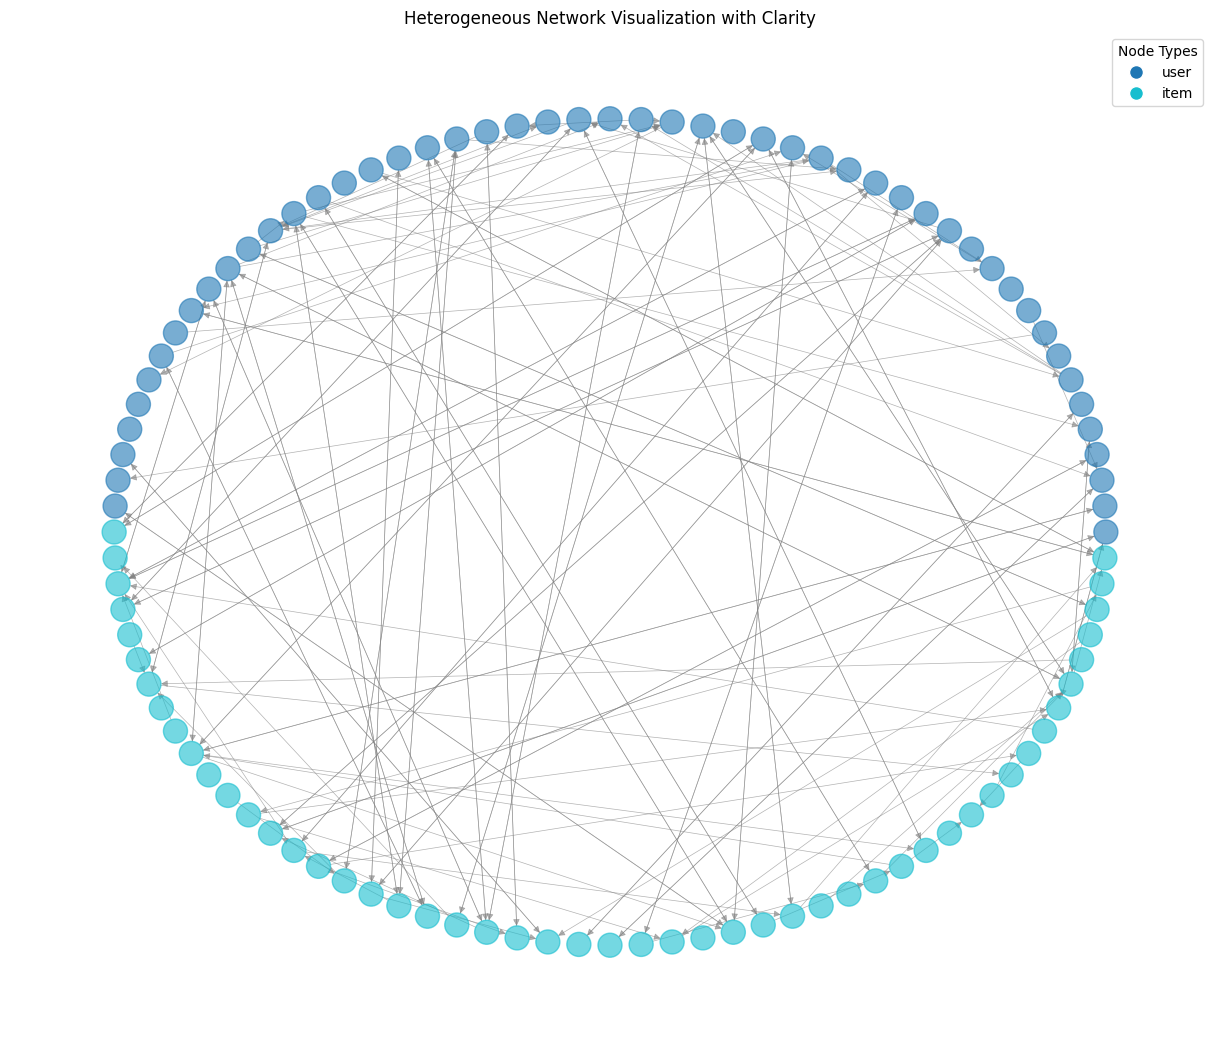

In [ ]:
visualize_hetero_graph_with_clarity(data, layout='circular', subset_size=50)

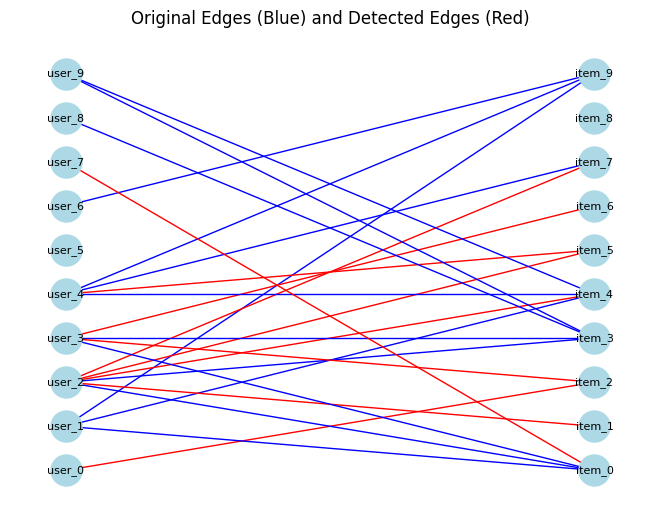

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

# Function to visualize the graph
def visualize_graph(user_item_edges, detected_edges, user_count, item_count):
    # Create a NetworkX graph
    G = nx.Graph()

    # Add user and item nodes
    for i in range(user_count):
        G.add_node(f"user_{i}", bipartite=0)
    for i in range(item_count):
        G.add_node(f"item_{i}", bipartite=1)

    # Add original edges
    for i in range(user_item_edges.size(1)):
        user, item = user_item_edges[:, i].tolist()
        G.add_edge(f"user_{user}", f"item_{item}", color='blue', label='Original')

    # Add detected edges
    for i in range(detected_edges.size(1)):
        user, item = detected_edges[:, i].tolist()
        if not G.has_edge(f"user_{user}", f"item_{item}"):  # Avoid duplicates
            G.add_edge(f"user_{user}", f"item_{item}", color='red', label='Detected')

    # Extract node positions for a bipartite layout
    pos = {}
    pos.update((node, (0, i)) for i, node in enumerate([f"user_{i}" for i in range(user_count)]))  # Left for users
    pos.update((node, (1, i)) for i, node in enumerate([f"item_{i}" for i in range(item_count)]))  # Right for items

    # Draw the graph
    edges = G.edges(data=True)
    colors = [edge[2]['color'] for edge in edges]

    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=500,
        node_color="lightblue",
        edge_color=colors,
        font_size=8
    )
    plt.title("Original Edges (Blue) and Detected Edges (Red)")
    plt.show()


# Example usage
user_item_edges = torch.randint(0, 10, (2, 15))  # Original edges
detected_edges = torch.randint(0, 10, (2, 10))   # Detected edges

visualize_graph(user_item_edges, detected_edges, user_count=10, item_count=10)


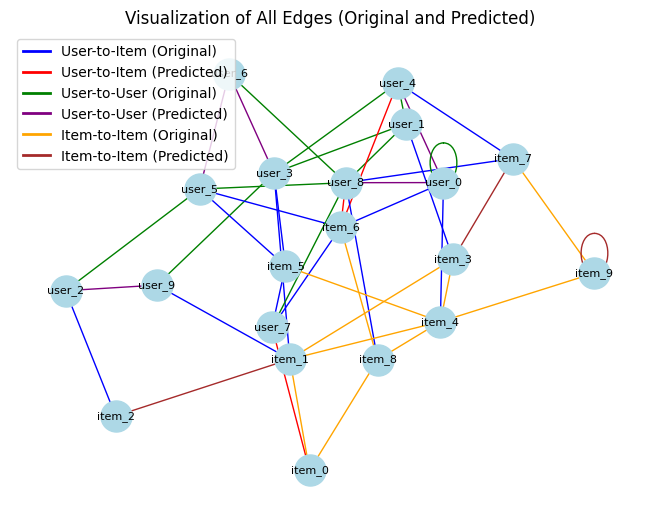

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

# Function to visualize the graph with all original and predicted links
def visualize_full_graph_with_predictions(
    user_item_edges,
    user_user_edges,
    item_item_edges,
    predicted_user_item_edges,
    predicted_user_user_edges,
    predicted_item_item_edges,
    user_count,
    item_count,
):
    # Create a NetworkX graph
    G = nx.Graph()

    # Add user and item nodes
    for i in range(user_count):
        G.add_node(f"user_{i}", bipartite=0)
    for i in range(item_count):
        G.add_node(f"item_{i}", bipartite=1)

    # Add user-to-user edges (original)
    for i in range(user_user_edges.size(1)):
        user1, user2 = user_user_edges[:, i].tolist()
        G.add_edge(f"user_{user1}", f"user_{user2}", color="green", label="User-to-User (Original)")

    # Add item-to-item edges (original)
    for i in range(item_item_edges.size(1)):
        item1, item2 = item_item_edges[:, i].tolist()
        G.add_edge(f"item_{item1}", f"item_{item2}", color="orange", label="Item-to-Item (Original)")

    # Add user-to-item edges (original)
    for i in range(user_item_edges.size(1)):
        user, item = user_item_edges[:, i].tolist()
        G.add_edge(f"user_{user}", f"item_{item}", color="blue", label="User-to-Item (Original)")

    # Add predicted user-to-item edges
    for i in range(predicted_user_item_edges.size(1)):
        user, item = predicted_user_item_edges[:, i].tolist()
        if not G.has_edge(f"user_{user}", f"item_{item}"):  # Avoid duplicates
            G.add_edge(f"user_{user}", f"item_{item}", color="red", label="User-to-Item (Predicted)")

    # Add predicted user-to-user edges
    for i in range(predicted_user_user_edges.size(1)):
        user1, user2 = predicted_user_user_edges[:, i].tolist()
        if not G.has_edge(f"user_{user1}", f"user_{user2}"):  # Avoid duplicates
            G.add_edge(f"user_{user1}", f"user_{user2}", color="purple", label="User-to-User (Predicted)")

    # Add predicted item-to-item edges
    for i in range(predicted_item_item_edges.size(1)):
        item1, item2 = predicted_item_item_edges[:, i].tolist()
        if not G.has_edge(f"item_{item1}", f"item_{item2}"):  # Avoid duplicates
            G.add_edge(f"item_{item1}", f"item_{item2}", color="brown", label="Item-to-Item (Predicted)")

    # Assign edge colors for visualization
    edges = G.edges(data=True)
    edge_colors = [edge[2]["color"] for edge in edges]

    # Draw the graph
    pos = nx.spring_layout(G, seed=42)  # Force-directed layout for better visualization
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=500,
        node_color="lightblue",
        edge_color=edge_colors,
        font_size=8,
    )
    # Create a legend
    legend_labels = {
        "blue": "User-to-Item (Original)",
        "red": "User-to-Item (Predicted)",
        "green": "User-to-User (Original)",
        "purple": "User-to-User (Predicted)",
        "orange": "Item-to-Item (Original)",
        "brown": "Item-to-Item (Predicted)",
    }
    handles = [plt.Line2D([0], [0], color=color, lw=2) for color in legend_labels.keys()]
    plt.legend(handles, legend_labels.values(), loc="upper left")
    plt.title("Visualization of All Edges (Original and Predicted)")
    plt.show()


# Example usage
# Original edges
user_item_edges = torch.randint(0, 10, (2, 15))  # Original user-item edges
user_user_edges = torch.randint(0, 10, (2, 10))  # Original user-to-user edges
item_item_edges = torch.randint(0, 10, (2, 10))  # Original item-to-item edges

# Predicted edges
predicted_user_item_edges = torch.randint(0, 10, (2, 5))  # Predicted user-item edges
predicted_user_user_edges = torch.randint(0, 10, (2, 5))  # Predicted user-to-user edges
predicted_item_item_edges = torch.randint(0, 10, (2, 5))  # Predicted item-to-item edges

# Visualize
visualize_full_graph_with_predictions(
    user_item_edges,
    user_user_edges,
    item_item_edges,
    predicted_user_item_edges,
    predicted_user_user_edges,
    predicted_item_item_edges,
    user_count=10,
    item_count=10,
)


In [ ]:
#Below Cells are not related to the IDP CODE they are for extra visulization

In [ ]:
!pip install pyvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.9 MB/s eta 0:00:00


In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize_hetero_graph_with_arrows(data, subset_size=None):
    """
    Visualize the heterogeneous graph using NetworkX with arrows on edges.

    Args:
    - data: The HeteroData object containing the graph.
    - subset_size: Number of nodes per type to display (None for full graph).
    """
    # Create an empty directed graph (for arrows)
    G = nx.DiGraph()

    # Add nodes with type attributes
    for node_type, node_data in data.x_dict.items():
        num_nodes = node_data.size(0)
        if subset_size:
            nodes_to_add = min(subset_size, num_nodes)
        else:
            nodes_to_add = num_nodes

        for i in range(nodes_to_add):
            G.add_node(f"{node_type}_{i}", type=node_type)

    # Add edges with edge types
    for (src, rel, dst), edge_index in data.edge_index_dict.items():
        for i in range(edge_index.size(1)):
            src_node = f"{src}_{edge_index[0, i].item()}"
            dst_node = f"{dst}_{edge_index[1, i].item()}"
            if src_node in G.nodes and dst_node in G.nodes:  # Check if nodes exist in the subset
                G.add_edge(src_node, dst_node, relation=rel)

    # Set up node colors by type
    node_color_map = {'user': 'blue', 'item': 'orange'}
    node_colors = [node_color_map[G.nodes[node]['type']] for node in G.nodes]

    # Draw the graph with arrows
    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(G, seed=42, k=0.3, iterations=50)  # Adjust spring layout parameters
    nx.draw(G, pos, node_color=node_colors, with_labels=True,
            node_size=500, font_size=8, font_color='black', arrows=True,
            width=0.5, alpha=0.7)  # Adjust edge width and transparency

    # Show the plot
    plt.title("Heterogeneous Graph with Directed Arrows")
    plt.show()

# Call the function to visualize the graph with directed arrows
visualize_hetero_graph_with_arrows(data, subset_size=50)
